In [24]:
import pymc
import numpy as np
rng = np.random.RandomState(1769)

# Some generated "observed" data
n = 5
x_a = rng.random_sample((2*n,))
x_b = 1 - x_a
# Add extra points just for 300 K
T = np.r_[1200 * rng.random_sample((n,)), np.array([300.] * n)]

# Priors on unknown parameters
H_ex = pymc.Uniform('H_ex', 0., 1e4, value=6e3)
S_ex = pymc.Uniform('S_ex',0., 10., value=0)
sig = pymc.Uniform('sig', 0., 100., value=10.)

# True model parameters, known only by nature
true_H_ex = 7e3
true_S_ex = 5
# Add some noise
noise = 0.01*8.3145*T*rng.normal(size=x_a.shape[-1]) 
obs_energies = 8.3145*T*(x_a*np.log(x_a)+x_b*np.log(x_b)) + (true_H_ex - T*true_S_ex)*x_a*x_b + noise

# Binary regular solution
def energy(H_ex, S_ex, T, x_a, x_b):
    return 8.3145*T*(x_a*np.log(x_a)+x_b*np.log(x_b)) + (H_ex - T*S_ex)*x_a*x_b

def entropy(H_ex, S_ex, T, x_a, x_b):
    return -(8.3145*(x_a*np.log(x_a)+x_b*np.log(x_b)) + (-S_ex)*x_a*x_b)

def enthalpy(H_ex, S_ex, T, x_a, x_b):
    return energy(H_ex, S_ex, T, x_a, x_b) - T*entropy(H_ex, S_ex, T, x_a, x_b)

# Fit to our energy model
@pymc.deterministic
def error(H_ex=H_ex, S_ex=S_ex, T=T, x_a=x_a, x_b=x_b, value=obs_energies):
    return np.abs(energy(H_ex, S_ex, T, x_a, x_b) - value).sum()

# Laplace likelihood for the error
e = pymc.Laplace('e', mu=error, tau=1.0/sig**2, value=obs_energies, observed=True)

In [25]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')
mod = pymc.Model([H_ex, S_ex, sig, e])
map_ = pymc.MAP(mod).fit()
MDL = pymc.MCMC(mod)
MDL.sample(iter=30000, burn=20000, thin=5, burn_till_tuned=True, progress_bar=False)

Plotting sig
Plotting S_ex
Plotting H_ex


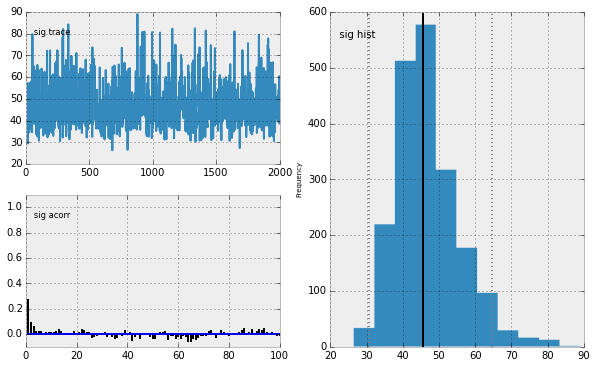

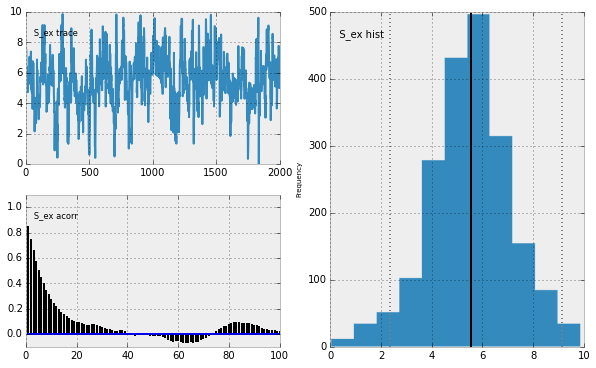

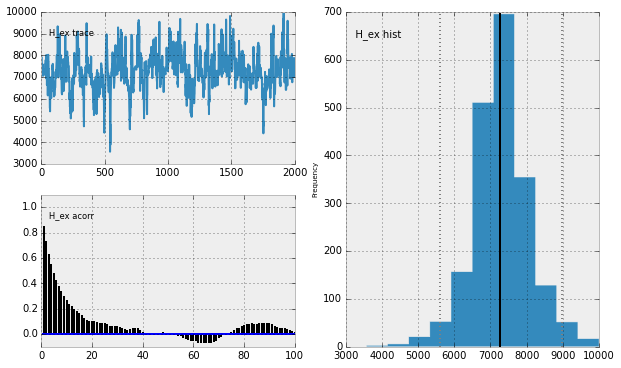

In [26]:
pymc.Matplot.plot(MDL)

In [27]:
print(MDL.stats()['H_ex']['95% HPD interval'])
print(MDL.stats()['S_ex']['95% HPD interval'])

[ 5617.97070819  8978.63987686]
[ 2.36116003  9.14382886]


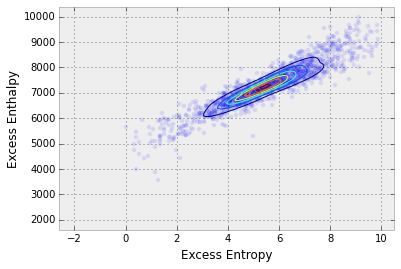

In [28]:
plt.scatter(S_ex.trace(), H_ex.trace(), alpha=0.1, zorder=1)
import scipy.stats
gkde = scipy.stats.gaussian_kde([S_ex.trace(), H_ex.trace()])
x,y = np.mgrid[-2:10:0.1, 2000:10000:100]
z = np.array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
plt.contour(x, y, z, linewidths=1, zorder=2)
plt.xlabel('Excess Entropy')
plt.ylabel('Excess Enthalpy')

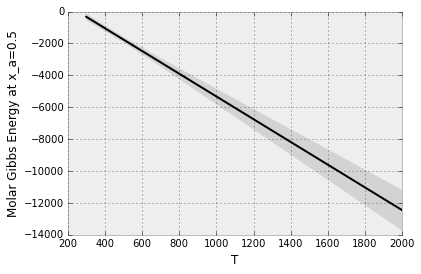

In [29]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
Tfit = np.linspace(300, 2000, 100)
Efit = energy(H_ex_tr[:, None], S_ex_tr[:, None], Tfit, 0.5, 0.5)
mu = Efit.mean(axis=0)
sig = 2 * Efit.std(axis=0)
plt.plot(Tfit, mu, '-k')
plt.fill_between(Tfit, mu - sig, mu + sig, color='lightgray')

plt.xlabel('T')
plt.ylabel('Molar Gibbs Energy at x_a=0.5')

In [30]:
temp = 300 # temperature of interest

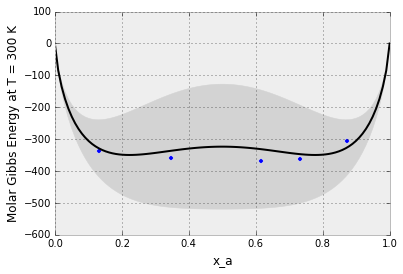

In [35]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = energy(H_ex_tr[:, None], S_ex_tr[:, None], temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sig = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

# Include the points from 300 K we specially observed
plt.scatter(x_a[n:], obs_energies[n:])
plt.xlim(0,1)
plt.xlabel('x_a')
plt.ylabel('Molar Gibbs Energy at T = {} K'.format(temp))

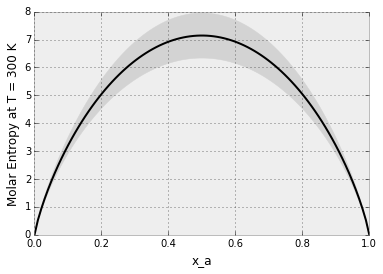

In [32]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = entropy(H_ex_tr[:, None], S_ex_tr[:, None], temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sig = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

plt.xlabel('x_a')
plt.ylabel('Molar Entropy at T = {} K'.format(temp))

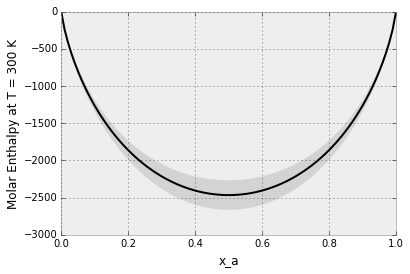

In [33]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = enthalpy(H_ex_tr[:, None], S_ex_tr[:, None], temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sig = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

plt.xlabel('x_a')
plt.ylabel('Molar Enthalpy at T = {} K'.format(temp))